In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import os
from PIL import Image
import re
import csv
import shutil
from skimage.morphology import dilation, erosion
from tqdm import tqdm


image_array = []
image_inds = []

# Add testing data to Cell_Data_Merge_MlLb
def extract_number(filename):
    pattern = r'man_seg(\d+).tif'
    match = re.search(pattern, filename)
    return int(match.group(1)) if match else None

# Test_folders= ["/data/MinaHossain/CellData/Cell_Data_LabelMe_Part2_New"]
Test_folders= ["/home/MinaHossain/Label_5004/Cell_Data_LabelMe_Part2_New"]

for tf in Test_folders:
    # Process images
    # Test_save= os.path.join(output_folder, '02')
    images=os.path.join(tf, '02_GT', "SEG")
    for filename in os.listdir(images):
        i = extract_number(filename)-1
        f = os.path.join(images, filename)
        img = Image.open(f).convert('L')
        image_array.append(img)
        image_inds.append(i)


image_array_2 = [x for _, x in sorted(zip(image_inds, image_array))]

# Starting the labels on the first frame

In [2]:
def make_np(img):
    return np.array(img)

def shuffle_labels(img, seed=789):
    # Find the unique labels, excluding 0 (background)
    array = make_np(img)
    unique_labels = np.unique(array[array != 0])

    # Generate new labels (random and unique) for each cell type
    # Ensure new labels do not conflict with existing labels
    # max_label = array.max()
    max_label = 0
    new_labels = np.arange(max_label + 1, max_label + 1 + len(unique_labels))

    # Randomly shuffle the new labels
    np.random.seed(seed)
    np.random.shuffle(new_labels)

    # Create a mapping from old labels to new labels
    label_mapping = {old: new for old, new in zip(unique_labels, new_labels)}

    # Apply the mapping to the array
    shuffled_array = np.copy(array)
    for old_label, new_label in label_mapping.items():
        shuffled_array[array == old_label] = new_label
    return shuffled_array

def plot_labels(shuffled, original, ax, title=None,
                txt_args={'color':'red', 'ha':'center', 'va':'center', 
                          'fontsize':'x-large', 'fontweight':'bold'}):
    ax.imshow(shuffled, cmap='gist_earth')
    ax.set_title(title)
    for label in np.unique(original):
        if label != 0:
            inds = np.argwhere(original == label)
            loc = inds.mean(0)
            ax.text(loc[1], loc[0], str(label), **txt_args)


def read_changes(file_path, row):
    with open(file_path, 'r') as handle:
        reader = csv.reader(handle, delimiter=' ')
        for i in range(row):
            next(reader)
        curr_row = next(reader)
        tuples = [tuple(map(int, item.split(','))) for item in curr_row]
    return tuples

def relabel_image(original, file_path, row):
    tuples = read_changes(file_path, row)
    new_img = original.copy()
    for t in tuples:
        new_img[original == t[0]] = t[1]
    return new_img

In [3]:
relabel_filepath = '6row_relabel.tsv'


When filling out _relabel.tsv, each row corresponds to the image row - 1.  
curr_idx is the frame of the image that will appear on the right, and has NOT been updated yet.  
To track the updates, put them on line curr_idx + 1.  
For example, if curr_idx=53, then image 53 will appear on the right (and not have updated yet).  
So we need to put the changes on line 54.  
Then when curr_idx = 54, image 54 will be on the right, and image 53 WITH corrections (from line 54) will be on the left.  

For each tuple, the first number is the original label, and the second number is the new label.  

So if we want for example cell 7 to be relabeled as cell 6, we would put "7,6" in the tsv.  

Separate each tuple with a space (don't add any spaces at the end of the line).

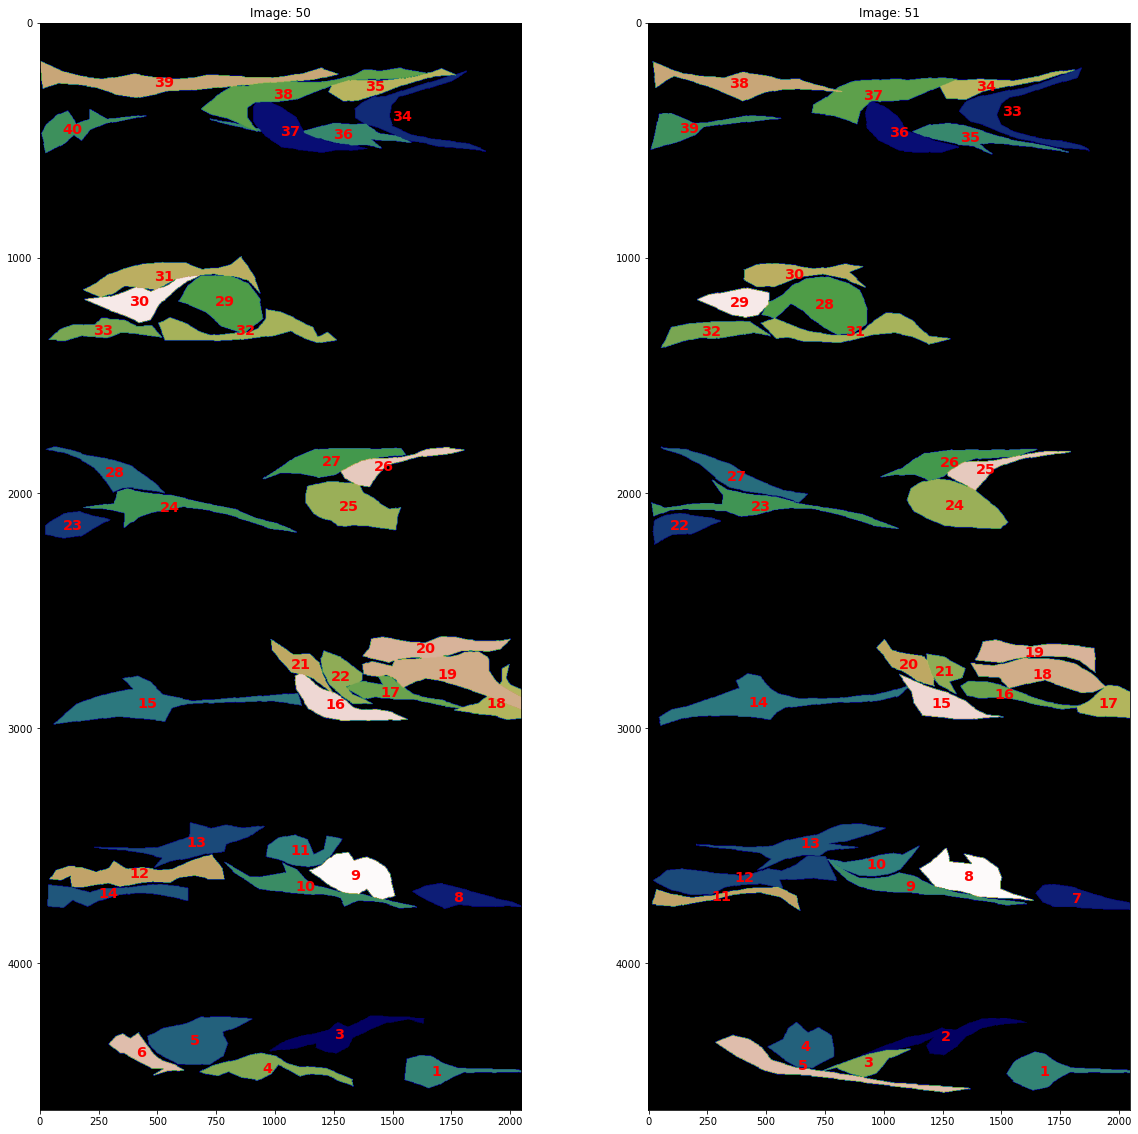

In [6]:
curr_idx = 51

prev_og = make_np(image_array_2[curr_idx-1])
if curr_idx - 1 != 0:
    prev_og = relabel_image(prev_og, relabel_filepath, curr_idx-1)
prev_img = shuffle_labels(prev_og)
curr_og = make_np(image_array_2[curr_idx])
curr_img = shuffle_labels(curr_og)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 20)
plot_labels(prev_img, prev_og, axs[0], title=f"Image: {curr_idx-1}")
plot_labels(curr_img, curr_og, axs[1], title=f"Image: {curr_idx}")

# Manually make the tracklets (man_track.txt)

In [ ]:
curr_idx = 1

prev_og = make_np(image_array_2[curr_idx-1])
if curr_idx - 1 != 0:
    prev_og = relabel_image(prev_og, relabel_filepath, curr_idx-1)
prev_img = shuffle_labels(prev_og)
curr_og = make_np(image_array_2[curr_idx])
curr_og = relabel_image(curr_og, relabel_filepath, curr_idx)
curr_img = shuffle_labels(curr_og)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 20)
plot_labels(prev_img, prev_og, axs[0], title=f"Image: {curr_idx-1}")
plot_labels(curr_img, curr_og, axs[1], title=f"Image: {curr_idx}")

# Manually track the labels (man_track.txt)

In [ ]:
for curr_idx in range(len(image_array_2)):
    prev_og = make_np(image_array_2[curr_idx])
    if curr_idx != 0:
        prev_og = relabel_image(prev_og, relabel_filepath, curr_idx)
    print(f"Frame {curr_idx} contains: {np.unique(prev_og)}")

    # curr_img = shuffle_labels(curr_og)


# Make new dataset based on corrections

In [ ]:
output_dir = "/home/MinaHossain/Label_5004/6row_images/"
mantrack_file = "/home/MinaHossain/Label_5004/6row_relabel_man_track.txt"
input_dir = Test_folders[0]

if not os.path.exists(output_dir):
    print("Copying directory")
    shutil.copytree(input_dir, output_dir)
else:
    print("Output exists")



Apply relabeling and save new tracking image

In [ ]:
for i in tqdm(range(len(image_array_2))):
    tmp_path = f"{output_dir}/02_GT/TRA/man_track{i:04d}.tif"
    if i == 0:
        image_array_2[i].save(tmp_path)
    else:
        tmp_img = make_np(image_array_2[i])
        relabeled_image = relabel_image(tmp_img, relabel_filepath, i)
        relabeled_image = Image.fromarray(relabeled_image, "L")
        relabeled_image.save(tmp_path)

Copy mantrack to new directory

In [ ]:
shutil.copy2(mantrack_file, f"{output_dir}/02_GT/TRA/man_track.txt")

Make sure all segs are 16 bit (i.e. np.uint16)

In [ ]:
folders_to_update = [
    f"{output_dir}/01_ST/SEG",
    f"{output_dir}/02_GT/SEG",
    f"{output_dir}/02_GT/TRA"
]

for folder in folders_to_update:
    for filename in tqdm(os.listdir(folder)):
        if filename.lower().endswith(".tif"):
            f = os.path.join(folder, filename)
            img = Image.open(f).convert('I')
            img = np.array(img, dtype=np.uint16)
            img = Image.fromarray(img)
            img.save(f)


In [ ]:
img = Image.open("/home/MinaHossain/Label_5004/6row_images/02/t0053.tif").convert('L')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 20)
axs[0].imshow(img, cmap='gist_gray', alpha=0.99)
img = process_image(img)
axs[1].imshow(img, cmap='gist_gray', alpha=0.99)

Apply adapthist to each image

In [ ]:
from skimage.exposure import equalize_adapthist
from scipy.stats import stats


def contrast_strech(img):
    imgori=img.copy()
    img=img.astype(np.float32)

    imgs = img.flatten()

    z = np.abs(stats.zscore(imgs))
    threshold = 2.5

    imgs = imgs[np.where(z <= threshold)]
    norm_v=(np.max(imgs) - np.min(imgs))
    if norm_v>0:
        imgnew = (img - np.min(imgs)) / norm_v
        #print (np.min(imgnew),np.max(imgnew))
        imgnew[imgnew <=0] = 0
        imgnew[imgnew >= 1] = 1
        imgnew=imgnew * 255
    else:
        imgnew=imgori
    imgnew=np.asarray(imgnew,dtype=np.uint8)
    return imgnew

def process_image(img):
    img = make_np(img)
    img = contrast_strech(img)
    img = 255 * equalize_adapthist(img)
    return img

In [ ]:
folders_to_update = [
    f"{output_dir}/01",
    f"{output_dir}/02",
]

for folder in folders_to_update:
    for filename in tqdm(os.listdir(folder)):
        if filename.lower().endswith(".tif"):
            f = os.path.join(folder, filename)
            img = Image.open(f).convert('L')
            img = process_image(img)
            img = Image.fromarray(img)
            img.save(f)
            

In [ ]:
# img = Image.open("/home/MinaHossain/Label_5004/6row_images/02/t0053.tif").convert('L')
# fig, axs = plt.subplots(1, 2)
# fig.set_size_inches(20, 20)
# axs[0].imshow(img, cmap='gist_gray', alpha=0.99)
# img = process_image(img)
# axs[1].imshow(img, cmap='gist_gray', alpha=0.99)

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import imageio

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 30)
og_img = imageio.imread(f"/home/MinaHossain/Label_5004/6row_images/01/t0010.tif")
#plt.imshow(og_img, cmap='gist_gray',alpha=0.9)

gt_mask=imageio.imread(f"/home/MinaHossain/Label_5004/6row_images/02/t0012.tif")
#plt.imshow(gt_mask, cmap='Set1',alpha=0.5)
ax[0].imshow(og_img, cmap='gist_gray',alpha=0.99)
ax[1].imshow(gt_mask,cmap='gist_gray', alpha=0.99)
plt.show()

# Generating segmentation maps (Did not using it)

In [ ]:
import skimage.io as sio
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


# mask = sio.imread("/home/MinaHossain/Label_5004/6row_images/01_ST/SEG/man_seg0000.tif")
# mask = 1 * (mask > 0)
# mask = np.asarray(np.expand_dims(mask, -1), dtype=np.int32)
# print(mask.shape[:2])
# segmap = SegmentationMapsOnImage(mask, shape=mask.shape[:2])

def process_mask(mask):
    mask = 1 * (mask > 0)
    mask = np.asarray(np.expand_dims(mask, -1), dtype=np.int32)
    segmap = SegmentationMapsOnImage(mask, shape=mask.shape[:2])
    return segmap

folders_to_update = [
    f"{output_dir}/01_ST/SEG",
    f"{output_dir}/02_GT/SEG",
]

for folder in folders_to_update:
    for filename in tqdm(os.listdir(folder)):
        if filename.lower().endswith(".tif"):
            f = os.path.join(folder, filename)
            mask = sio.imread(f)
            segmap = process_mask(mask)
            np.save(f, segmap)

In [ ]:
# mask = sio.imread("/home/MinaHossain/Label_5004/6row_images/01_ST/SEG/man_seg0000.tif")
mask = np.array(Image.open("/home/MinaHossain/Label_5004/6row_images/01_ST/SEG/man_seg0000.tif"))
mask = 1 * (mask > 0)
mask = np.asarray(np.expand_dims(mask, -1), dtype=np.int32)
print(mask.shape[:2])
segmap = SegmentationMapsOnImage(mask, shape=mask.shape[:2])

## Verify

In [ ]:
seg_img = Image.open("/home/MinaHossain/Label_5004/6row_images/02_GT/SEG/man_seg0050.tif").convert('L')
tra_img = Image.open("/home/MinaHossain/Label_5004/6row_images/02_GT/TRA/man_track0050.tif").convert('L')


seg_shuf = shuffle_labels(make_np(seg_img))
tra_shuf = shuffle_labels(make_np(tra_img))

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 20)

plot_labels(seg_shuf, make_np(seg_img), axs[0], "SEG")
plot_labels(tra_shuf, make_np(tra_img), axs[1], "TRA")

# Verify the Plot

In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
# from skimage.segmentation import relabel_sequential


def shuffle_labels(img, seed=78):
    # Find the unique labels, excluding 0 (background)
    # array = make_np(img)
    array = img
    unique_labels = np.unique(array[array != 0])

    # Generate new labels (random and unique) for each cell type
    # Ensure new labels do not conflict with existing labels
    # max_label = array.max()
    max_label = 0
    new_labels = np.arange(max_label + 1, max_label + 1 + len(unique_labels))

    # Randomly shuffle the new labels
    np.random.seed(seed)
    np.random.shuffle(new_labels)

    # Create a mapping from old labels to new labels
    label_mapping = {old: new for old, new in zip(unique_labels, new_labels)}

    # Apply the mapping to the array
    shuffled_array = np.copy(array)
    for old_label, new_label in label_mapping.items():
        shuffled_array[array == old_label] = new_label
    return shuffled_array

def plot_labels(shuffled, original, ax, title=None,
                txt_args={'color':'red', 'ha':'center', 'va':'center', 
                          'fontsize':'x-large', 'fontweight':'bold'}):
    ax.imshow(shuffled, cmap='gist_earth')
    ax.set_title(title)
    for label in np.unique(original):
        if label != 0:
            inds = np.argwhere(original == label)
            loc = inds.mean(0)
            ax.text(loc[1], loc[0], str(label), **txt_args)


# Data_file = 'Labelme_Part1A'
data_type =  "P2" #"P1" #"M"  
# Data_file = 'Labelme_P22'
# Data_file = 'Cell-Data-P2AA'
# if not os.path.exists(f"/home/MinaHossain/DMNet_Rina/Plot_DM-Net/{Data_file}/"):
#     os.makedirs(f"/home/MinaHossain/DMNet_Rina/Plot_DM-Net/{Data_file}/")


for i in range(150,155):
    # Path to the raw image (like datasets/raw/Cell_Data/02/imagename.tif)
    og_img = tiff.imread(f"/home/MinaHossain/DMNet_Rina/training_codes/Data/train/Cell-Data-{data_type}/02/t{i:04d}.tif")

    # Path to the actual mask (like datasets/raw/Cell_Data/02_GT/SEG/imagename.tif)
    st_mask=tiff.imread(f"/home/MinaHossain/DMNet_Rina/training_codes/Data/train/Cell-Data-{data_type}/02_GT/SEG/man_seg{i:04d}.tif")
    st_mask_shuffled = shuffle_labels(st_mask)
    # gt_mask = np.ma.masked_where(gt_mask == 0, gt_mask)
                  
    tk_mask=tiff.imread(f"/home/MinaHossain/Label_5004/6row_images/02_GT/TRA/man_track{i:04d}.tif")
    # tk_mask=tiff.imread(f"/home/MinaHossain/DMNet_Rina/Cell-Data-{data_type}/07_RES-GT/mask{i:04d}.tif")
    # f"/home/MinaHossain/Label_5004/6row_images/02_GT/TRA/man_track{i:04d}.tif"
    # pred_mask1, _, __ = relabel_sequential(pred_mask1)
    tk_mask_shuffled = shuffle_labels(tk_mask)
    # pred_mask1 = np.ma.masked_where(pred_mask1 == 0, pred_mask1)


    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(20, 13)
    fig.suptitle('Test results from DMNet ',fontsize=20)
    
    ax[0].imshow(og_img, cmap='gist_gray', alpha=0.99)
    plot_labels(st_mask_shuffled, st_mask, ax[1], f"Ground Truth for Segmentation (img {i:04d})")
    plot_labels(tk_mask_shuffled, tk_mask, ax[2], f"Ground Truth for Tracking (img {i:04d})")

    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    # plt.savefig(f"/home/MinaHossain/DMNet_Rina/Plot_DM-Net/{Data_file}/{i:04d}.png")
    plt.show()
    